In [49]:
import numpy as np
import pandas as pd

import matplotlib.pylab as pylab
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.4)

params = {'legend.fontsize': 20,
          'figure.figsize': (8, 5),
         'axes.labelsize': 24,
         'axes.titlesize':16,
         'xtick.labelsize':18,
         'ytick.labelsize':18}
mpl.rc('font',family='Times New Roman')
pylab.rcParams.update(params)
cmap = plt.cm.viridis
count = 10
color = [cmap(round(i/count*cmap.N)) for i in range(count)]

In [50]:
# Read all data

dft = pd.read_csv('data/defect/dft_info.csv')
ad1 = pd.read_csv('data/defect/Adsorption_ethene_ethane.csv')
ad2 = pd.read_csv('data/defect/Adsorption_CO2_methanol.csv')
ad = pd.concat([ad1, ad2], ignore_index=True, sort=False)

temp = pd.read_csv('data/Data_S1.csv')
feature = temp[temp['molecule']=='ethane'][temp.columns[2:101]]
feature['MOF'] = temp[temp['molecule']=='ethane']['MOF']

df = pd.DataFrame()

df['MOF'] = [x.split('_')[0] for x in ad['mof']]
df['adsorbate'] = ad['ad']
df['conc'] = [float(x.split('_')[1]) if len(x.split('_')) == 2 else 0 for x in ad['conc']]
df['p'] = ad['p']
df['q'] = ad['q']

temp = dft[dft['conc']=='0']
temp['MOF'] = [x.split('_')[0] for x in temp['mof'] ] 
temp['MPDC'] = temp['max'].values
df = pd.merge(df,temp[['MOF','MPDC']],on='MOF')

molData=np.array([
    ['xe',131.293,289.7,58.4,0.008,164.87,161.2,3.96], 
    ['butane',58.1,449.8,39.5,0.3,280.1,146.7,4.68], 
    ['propene',42.1,436.9,51.7,0.2,254.8,150.6,4.50], 
    ['ethane',30.1,381.8,50.3,0.2,184.0,126.2,4.44], 
    ['propane',44.1,416.5,44.6,0.2,230.1,136.5,4.30], 
    ['CO2',44.0,295.9,71.8,0.2,317.4,204.9,3.3], 
    ['ethene',28.054,282.5,51.2,0.089,169.3,228,4.16], 
    ['methane',16.04,190.4,46.0,0.011,111.5,91,3.80],
    ['kr',83.798,209.4,55.0,0.005,119.6,115.6,3.6],
    ['methanol',32.04,513.4,82.2,0.556,337.85,175.6,3.6]])

df_mol = pd.DataFrame(data=molData, columns=["adsorbate", "Mw/gr.mol-1", "Tc/K", "Pc/bar", "w", "Tb/K", "Tf/K",'d'])

megnet = pd.read_csv('data/megnet_properties.csv')
df = pd.merge(df,megnet,on='MOF')
df = pd.merge(df,feature,on='MOF')

df = pd.merge(df,df_mol,on='adsorbate')



df['ratio'] = np.log10([ x['q']/df[(df['MOF']==x['MOF']) & (df['conc']==0) & (df['p']==x['p']) & (df['adsorbate']==x['adsorbate'])]['q'].values[0] for ndex,x in df.iterrows()])
df = df.replace([np.inf], 0.3)
df = df.replace([-np.inf], -0.3)

df['class'] = df['ratio']
df['class'] = df['class'].apply(lambda x: -1 if x < -0.1 else x)
df['class'] = df['class'].apply(lambda x: 0 if x > -0.1 and x < 0.1 else x)
df['class'] = df['class'].apply(lambda x: 1 if x > 0.1 else x)
df = df.dropna(axis=0)

df.to_csv('data/defect_data.csv')

# feature scale
print(len(df))
df_norm = df[df.columns[2:-2]]
df_norm = df_norm[df_norm['conc']<=df_norm['MPDC']]
print(len(df_norm))

df_norm = df_norm.astype(float)
df_norm = df_norm.loc[:, [len(np.unique(df_norm[x])) > 2 for x in df_norm.columns]]
df_norm = (df_norm-df_norm.min())/(df_norm.max()-df_norm.min())

df_norm = df_norm.dropna(axis=1)

/tmp/ipykernel_3280554/2771316591.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['MOF'] = [x.split('_')[0] for x in temp['mof'] ]
/tmp/ipykernel_3280554/2771316591.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['MPDC'] = temp['max'].values
/tmp/ipykernel_3280554/2771316591.py:47: RuntimeWarning: divide by zero encountered in log10
  df['ratio'] = np.log10([ x['q']/df[(df['MOF']==x['MOF']) & (df['conc']==0) & (df['p']==x['p']) & (df['adsorbate']==x['adsorbate'])]['q'].values[0] for ndex

7265
5397


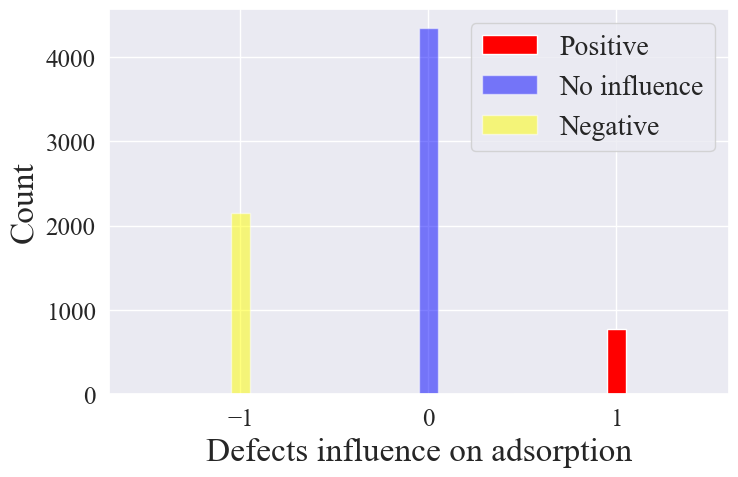

In [51]:
X_original = df[df.columns[0:-2]]
y_original = df[df.columns[-2]]
y_class_original = df[df.columns[-1]]

fig, ax = plt.subplots()
ax.hist(y_class_original[y_class_original==1], alpha=1.0, color='red', label='Positive',align='left')
ax.hist(y_class_original[y_class_original==0], alpha=0.5, color='blue', label='No influence',align='left')
ax.hist(y_class_original[y_class_original==-1], alpha=0.5, color='yellow', label='Negative',align='left')

ax.set_xlabel('Defects influence on adsorption')
ax.set_ylabel('Count')
plt.xticks([-1,0,1])
ax.legend()

fig.savefig('fig/defect_hist.jpg',dpi=500,bbox_inches='tight')

In [52]:
### classification train test split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
normalized_data = scaler.fit_transform(df[df.columns[2:-2]])
normalized_df = pd.DataFrame(normalized_data, columns=df[df.columns[2:-2]].columns)

selected_features = list(normalized_df.columns[0:11]) + ['d']

X_train_MOF, X_test_MOF, y_train_MOF, y_test_MOF = train_test_split(normalized_df[selected_features], df[df.columns[-1]], test_size=0.2, shuffle=False )

# X_train, X_test, y_train, y_test = train_test_split(normalized_df[normalized_df.columns[0:7]], df[df.columns[-1]], test_size=0.2, random_state=0, shuffle=True)
X_train = normalized_df[selected_features]
X_test = X_train
y_train = df[df.columns[-1]]
y_test = y_train


desired_order = ['ethene', 'ethane', 'propane', 'kr', 'butane', 'xe', 'propene'] 
df['sort'] = pd.Categorical(df['adsorbate'], categories=desired_order, ordered=True)
df = df.sort_values('sort')
df = df.drop(columns='sort')

scaler = StandardScaler()
normalized_data = scaler.fit_transform(df[df.columns[2:-2]])
normalized_df = pd.DataFrame(normalized_data, columns=df[df.columns[2:-2]].columns)

X_train_adsorbate, X_test_adsorbate, y_train_adsorbate, y_test_adsorbate = train_test_split( normalized_df[selected_features], df[df.columns[-1]], test_size=0.2, shuffle=False)

Best Parameters:  {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
Best Score:  0.644322092222987
Test Accuracy:  0.8346868547832071
[[1788  262   94]
 [ 457 3608  283]
 [  48   57  668]]
[[3576  524  188]
 [ 914 7216  566]
 [  96  114 1336]]
Test Accuracy:  0.8346868547832071


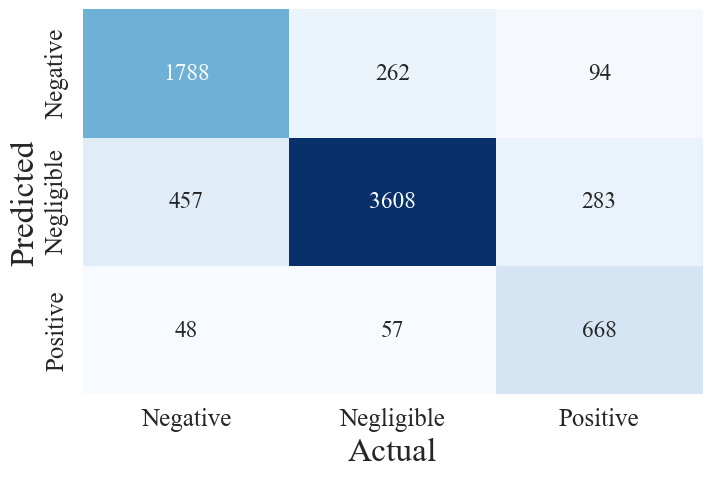

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Define the parameter grid for the grid search
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf'],
    'gamma': [0.1, 1, 'scale', 'auto'],
}

# Create an SVM classifier
svm = SVC(decision_function_shape='ovo', class_weight='balanced', probability=True, random_state=0)

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

# Evaluate the model on the test set
best_model = grid_search.best_estimator_
y_test_predicted = best_model.predict(X_test)
y_train_predicted = best_model.predict(X_train)
accuracy = accuracy_score(y_test, y_test_predicted)
print("Test Accuracy: ", accuracy)
accuracy = accuracy_score(y_train, y_train_predicted)
print("Train Accuracy: ", accuracy)

y_all = np.concatenate((y_train_predicted, y_test_predicted))
y_true =  np.concatenate((y_train, y_test))
X_all = pd.concat([X_train, X_test], axis=0)

test_matrix = confusion_matrix(y_test, y_test_predicted)
print(test_matrix)
all_matrix = confusion_matrix(y_true, y_all)
print(all_matrix)

# Create a figure and axes
fig, ax = plt.subplots()
label_name = ['Negative', 'Negligible', 'Positive']
sns.heatmap(test_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=label_name, yticklabels=label_name, ax=ax)

# Set the axis labels and title
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')

# Show the plot
plt.show()
fig.savefig('fig/defect_classification_MOF_confusion_matrix.jpg',dpi=500,bbox_inches='tight')

# Best Parameters:  {'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [54]:
from sklearn.decomposition import PCA

scaler = StandardScaler()
normalized_data = scaler.fit_transform(df[df.columns[4:-1]])

pca = PCA(n_components=10)
pca.fit(normalized_data)
pca_df = pca.transform(normalized_data)

print(pca.explained_variance_ratio_)

from sklearn.decomposition import PCA
import numpy as np

# Obtain the component matrix
component_matrix = pca.components_

from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel,RBF
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,GridSearchCV


X, y = pca_df, df['ratio']
X_train_regression, X_test_regression, y_train_regression, y_test_regression = train_test_split(X, y, test_size=0.2, random_state=0)

# Define the kernel for the Gaussian process
kernel1,kernel2,kernel3 = RBF(length_scale_bounds=(1e-9,1e9)), WhiteKernel(noise_level_bounds=(1e-9,1e9)) + RBF(length_scale_bounds=(1e-9,1e9)), DotProduct(sigma_0_bounds=(1e-9,1e9))+WhiteKernel(noise_level_bounds=(1e-9,1e9))
# Create the Gaussian Process Regression model
gpr = GaussianProcessRegressor()
# Define hyperparameters to tune
param_grid = {'alpha': [0.01, 0.1, 1, 10], 
              'kernel': [kernel1, kernel2, kernel3],
              }

# Perform k-fold cross-validation with hyperparameter tuning
kfold = KFold(n_splits=5, shuffle=True)
grid_search = GridSearchCV(gpr, param_grid, cv=kfold, scoring='neg_mean_squared_error')
grid_search.fit(X_train_regression, y_train_regression)

print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", np.sqrt(-grid_search.best_score_))

best_gpr_model = grid_search.best_estimator_
best_gpr_model.fit(X_train_regression, y_train_regression)
y_test_predict, y_test_predict_std = best_gpr_model.predict(X_test_regression, return_std=True)
y_all_predict, y_all_predict_std = best_gpr_model.predict(X, return_std=True)

[0.25386603 0.15361801 0.08812525 0.07309628 0.05672589 0.05532845
 0.04002447 0.03643427 0.03565499 0.0320648 ]


/home/zhenzi/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__noise_level is close to the specified lower bound 1e-09. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/zhenzi/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__noise_level is close to the specified lower bound 1e-09. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/zhenzi/anaconda3/envs/ML/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__noise_level is close to the specified lower bound 1e-09. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/zhenzi/anaconda3/envs/ML/lib/pytho

Best Hyperparameters:  {'alpha': 0.01, 'kernel': RBF(length_scale=1)}
Best Score:  0.015072851445448572


In [70]:
len(X_test)

7265

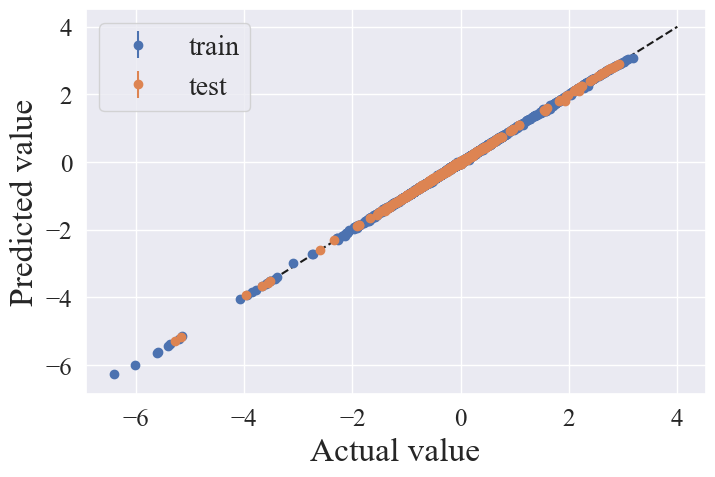

In [75]:
best_gpr_model = grid_search.best_estimator_
best_gpr_model.fit(X_train_regression, y_train_regression)
y_test_predict, y_test_predict_std = best_gpr_model.predict(X_test_regression, return_std=True)
y_train_predict, y_train_predict_std = best_gpr_model.predict(X_train_regression, return_std=True)

fig, ax = plt.subplots()
ax.errorbar(y_train_regression, y_train_predict,  yerr = y_train_predict_std, fmt='o', label="train")
ax.errorbar(y_test_regression, y_test_predict, yerr = y_test_predict_std, fmt='o', label="test")
ax.plot([-4,4],[-4,4],color='k',ls='--')
ax.plot([])

ax.legend()
ax.set_xlabel('Actual value')
ax.set_ylabel("Predicted value")

from sklearn.metrics import r2_score
r2_score(y_test_predict, y_test_regression)
fig.savefig('fig/defect_regression.jpg',dpi=500,bbox_inches='tight')
#plt.title("Gaussian process regression on noise-free dataset")

In [55]:
import keras

# Define the input data
input_data = keras.Input(shape=(10,))

# Define the shared layers
shared_layers = keras.layers.Dense(128, activation='relu')(input_data)

# Define the first task
task_1_output = keras.layers.Dense(1)(shared_layers)

# Define the second task
task_2_output = keras.layers.Dense(1)(shared_layers)

# Define the model
model = keras.Model(input_data, [task_1_output, task_2_output])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=10)

# Evaluate the model
model.evaluate(X_test, y_test)

Epoch 1/10


ValueError: in user code:

    File "/home/zhenzi/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/zhenzi/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/zhenzi/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/zhenzi/.local/lib/python3.10/site-packages/keras/engine/training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "/home/zhenzi/.local/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/zhenzi/.local/lib/python3.10/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_4" is incompatible with the layer: expected shape=(None, 10), found shape=(None, 12)
